# Setup

In [1]:
%load_ext autoreload
%autoreload 2
%aimport

Modules to reload:
all-except-skipped

Modules to skip:



In [6]:
%matplotlib inline

In [7]:
from relaxed.plot_defaults import *

In [8]:
import astropy
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt 
import re 
from astropy.table import Table
import astropy.table
import json
from scipy import stats
from copy import deepcopy
import scipy
import warnings
from tqdm import tqdm

import matplotlib as mpl
from sklearn.model_selection import train_test_split


In [9]:
from relaxed.analysis import get_mah, add_box_indices, get_tt_indices, alpha_analysis
from relaxed.models import training_suite
from relaxed import halo_catalogs


# Data

In [10]:
mah_data = get_mah('m12', '../../output/', cutoff_missing=0.05, cutoff_particle=0.05)

In [11]:
# catalog
cat = mah_data['cat']
xoff = cat['x0']
cvir = cat['cvir']
eta = cat['eta']
spin = cat['spin']
voff = cat['v0']
# spin_b = cat['spin_bullock'] # need to add catalog 
# m2 = cat['m2_a179'], fraction of largest subhalo mass 
# separate b/a and c/a ?? 
q = cat['q']
ma = mah_data['ma']
am = mah_data['am']

scales = mah_data['scales']
mass_bins = mah_data['mass_bins']
print(cvir.shape, xoff.shape, eta.shape, am.shape, ma.shape, scales.shape, mass_bins.shape)

(10000,) (10000,) (10000,) (10000, 100) (10000, 165) (165,) (100,)


In [12]:
alphas, ma_exp, am_exp = alpha_analysis(ma, scales, mass_bins)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [01:24<00:00, 117.71it/s]


In [13]:
# add box indices to cat for uncertainty purposes
add_box_indices(cat)

In [14]:
# train/test split
train_idx, test_idx = get_tt_indices(len(cat), test_ratio=0.3)
cat_train, am_train, cvir_train, xoff_train, eta_train, voff_train, q_train, spin_train, alpha_train = (cat[train_idx], am[train_idx], cvir[train_idx], 
                                                           xoff[train_idx], eta[train_idx], voff[train_idx], q[train_idx], spin[train_idx], alphas[train_idx])
cat_test, am_test, cvir_test, xoff_test, eta_test, voff_test, q_test, spin_test, alpha_test = (cat[test_idx], am[test_idx], cvir[test_idx], 
                                                     xoff[test_idx], eta[test_idx], voff[test_idx], q[test_idx], spin[test_idx], alphas[test_idx])
print(cvir_train.shape, cvir_test.shape, alpha_train.shape)

(7000,) (3000,) (7000, 1)


# Train

In [ ]:
# cvir models
data = {
    'cam_1/2': {
        'xy': (am_train, cvir_train), 'n_features': am_train.shape[1], 'n_targets': 1, 'model': 'cam',
        'kwargs': {'mass_bins': mass_bins, 'mbin': 0.50, 'cam_order': -1}},
    'linear': {
        'xy': (am_train, cvir_train), 'n_features': am_train.shape[1], 'n_targets': 1, 'model': 'linear',
        'kwargs': {}},
    'linear_alpha': {
        'xy': (alpha_train, cvir_train), 'n_features': 1, 'n_targets': 1, 'model': 'linear',
        'kwargs': {}},
    'linear_marginal': {
        'xy': (am_train, cvir_train), 'n_features': am_train.shape[1], 'n_targets': 1, 'model': 'linear',
        'kwargs': {'to_marginal_normal':True, 'use_multicam':False}},
    'lognormal': {
        'xy': (am_train, cvir_train), 'n_features': am_train.shape[1], 'n_targets': 1, 'model': 'lognormal', 'kwargs': {}
    },
    'gaussian': {
        'xy': (am_train, cvir_train), 'n_features': am_train.shape[1], 'n_targets': 1, 'model': 'gaussian', 
        'kwargs': {'to_marginal_normal':True , 'use_multicam': True},
    },
}
cvir_models = training_suite(data)

# eta models
data = {
    'cam_1/2': {
        'xy': (am_train, eta_train), 'n_features': am_train.shape[1], 'n_targets': 1, 'model': 'cam',
        'kwargs': {'mass_bins': mass_bins, 'mbin': 0.5, 'cam_order': +1}},
    'cam_peak': {
        'xy': (am_train, eta_train), 'n_features': am_train.shape[1], 'n_targets': 1, 'model': 'cam',
        'kwargs': {'mass_bins': mass_bins, 'mbin': 0.738, 'cam_order': +1}},
    'linear': {
        'xy': (am_train, eta_train), 'n_features': am_train.shape[1], 'n_targets': 1, 'model': 'linear',
        'kwargs': {}},
    'lognormal': {
        'xy': (am_train, eta_train), 'n_features': am_train.shape[1], 'n_targets': 1, 'model': 'lognormal', 'kwargs': {}
    },
    'gaussian': {
        'xy': (am_train, eta_train), 'n_features': am_train.shape[1], 'n_targets': 1, 'model': 'gaussian', 
        'kwargs': {},
    },
}

eta_models = training_suite(data)

# xoff models
data = {
    'cam_1/2': {
        'xy': (am_train, xoff_train), 'n_features': am_train.shape[1], 'n_targets': 1, 'model': 'cam',
        'kwargs': {'mass_bins': mass_bins, 'mbin': 0.5, 'cam_order': +1}},
    'cam_peak': {
        'xy': (am_train, xoff_train), 'n_features': am_train.shape[1], 'n_targets': 1, 'model': 'cam',
        'kwargs': {'mass_bins': mass_bins, 'mbin': 0.738, 'cam_order': +1}},
    'linear': {
        'xy': (am_train, xoff_train), 'n_features': am_train.shape[1], 'n_targets': 1, 'model': 'linear',
        'kwargs': {}},
    'lognormal': {
        'xy': (am_train, xoff_train), 'n_features': am_train.shape[1], 'n_targets': 1, 'model': 'lognormal', 'kwargs': {}
    },
    'gaussian': {
        'xy': (am_train, xoff_train), 'n_features': am_train.shape[1], 'n_targets': 1, 'model': 'gaussian', 
        'kwargs': {'to_marginal_normal':True , 'use_multicam': True},
    },
}
xoff_models = training_suite(data)

# joint models
y_train = np.hstack([cvir_train.reshape(-1, 1), eta_train.reshape(-1, 1), xoff_train.reshape(-1, 1), 
                     spin_train.reshape(-1, 1), q_train.reshape(-1, 1)])
data ={
    'multi_gaussian': {
        'xy': (am_train, y_train), 'n_features': am_train.shape[1], 'n_targets': 5, 'model': 'gaussian',
        'kwargs': {'to_marginal_normal':True , 'use_multicam': True},
    }, 
    'multi_gaussian_alpha': {
        'xy': (alpha_train, y_train), 'n_features': 1, 'n_targets': 5, 'model': 'gaussian',
        'kwargs': {'to_marginal_normal':True , 'use_multicam': True},
    }, 

    'lognormal': {
        'xy': (am_train, y_train), 'n_features': am_train.shape[1], 'n_targets': 5, 'model': 'lognormal', 'kwargs': {}
    },
}
joint_models = training_suite(data)

# Prediction Plots

## Combined histogram of residuals

In [198]:
from relaxed.analysis import vol_jacknife_err

def summary_statistics(model, _x_test, _y_test, box_keep = None):
    if box_keep is None:
        box_keep = np.ones(_x_test.shape[0]).astype(bool)
    
    x_test = _x_test[box_keep]
    y_test = _y_test[box_keep].reshape(-1)
    
    y_pred = model.predict(x_test).reshape(-1)
    x = (y_pred - y_test) / np.std(y_test) # normalize

    return {'mu': np.mean(x), 
            'med': np.median(x),
            'sigma_ratio': np.std(y_pred) / np.std(y_test), 
            'sigma_rratio': np.std(y_pred - y_test) / np.std(y_test), 
            'corr': scipy.stats.spearmanr(y_pred, y_test)[0],
            'scatter': np.std(x)
           }


# test_data is a dictionary containing the information for testing each model.
def combined_histogram(test_data: dict, y_test, trained_models, n_bins=31, latex_var="", 
                       xrange=(-3, 3), figsize=(20, 10), legend_size=20, log=False, 
                       calc_errs = False, cat_test=None, draw_vline=True):
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    bins = None
    for name, (x_test, label, color) in test_data.items():
        model = trained_models[name]
        assert model.n_targets == 1
        y_pred = model.predict(x_test).reshape(-1)
        x = (y_pred - y_test) / np.std(y_test) # normalize
        summ = summary_statistics(model, x_test, y_test)
          
        if bins is None: 
            bins = get_bins(x, range=xrange, bins=n_bins) # share bins between all histograms.
      
        label1 = f"{label}, $(\\rho, \\mu, \\mu', \\sigma_p / \\sigma_t, \\sigma_x) ="
        label2 = f"({summ['corr']:.2f}, {summ['mu']:.2f}, {summ['med']:.2f}, {summ['sigma_ratio']:.2f}, {summ['scatter']:.2f})$"

        # calculate uncertainties
        if calc_errs:
            assert cat_test is not None
            err = vol_jacknife_err(summary_statistics, cat_test, model, x_test, y_test, mode='dict')
            label2 = (f"({summ['corr']:.2f} \\pm {err['corr']:.2f}, {summ['mu']:.2f} \\pm {err['mu']:.2f},"
                     f"{summ['med']:.2f} \\pm {err['med']:.2f}, {summ['sigma_ratio']:.2f} \\pm {err['sigma_ratio']:.2f}, {summ['scatter']:.2f} \\pm {err['scatter']:.2f})$")
        label = label1 + label2

        draw_histogram(ax, x, vline=summ['mu']if draw_vline else None, label=label, color=color, bins=bins, density=False)
        
    ax.set_ylabel(r"\rm Counts", size=28)
    
    v_pred = latex_var + r"^{\rm pred}"
    v_test = latex_var + r"^{\rm true}"
    
    ax.set_xlabel(f"$({v_pred} - {v_test}) / \\sigma({v_test})$", size=28)
    
    if log: 
        ax.set_yscale('log')
        
    if draw_vline:
        ax.axvline(0, color='k', ls='--')


        
    # format legend
    ax.legend(loc='lower left', prop={'size':legend_size}, bbox_to_anchor=(0., 1.02, 1., .202), 
              ncol=1,  borderaxespad=0.)

### Cvir

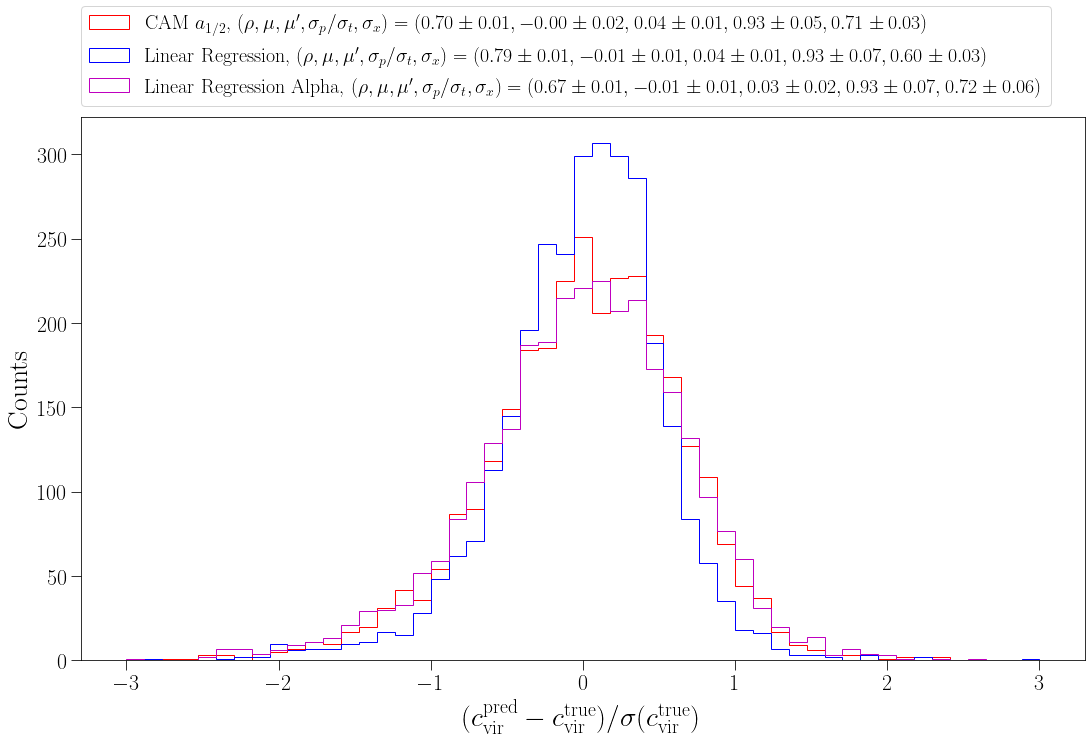

In [200]:
test_data = {'cam_1/2': (am_test, "\\rm CAM $a_{1/2}$", 'r'),
            'linear': (am_test, "\\rm Linear Regression", 'b'),
            'linear_alpha': (alpha_test, "\\rm Linear Regression Alpha", 'm'),
#             'linear_marginal': (am_test, "\\rm Linear Regression (Marginal)", 'm'),
#             'lognormal': (am_test, "\\rm Lognormal Samples", 'orange'),
#             'gaussian': (am_test, "\\rm Gaussian", 'g'), 
            }

combined_histogram(test_data, cvir_test, cvir_models, latex_var=r'c_{\rm vir}', n_bins=51, xrange=(-3, 3), 
                   calc_errs=True, cat_test=cat_test, figsize=(18, 10), draw_vline=False)

### Xoff

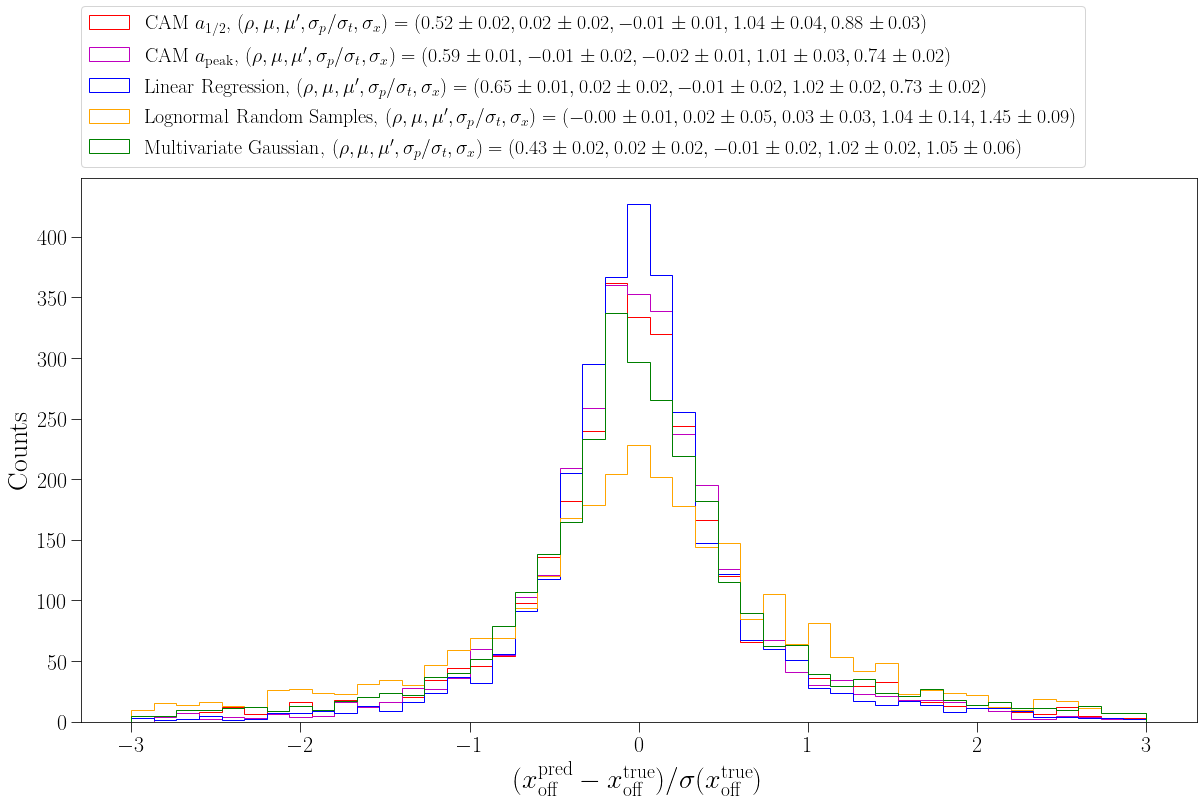

In [40]:
test_data = {'cam_1/2': (am_test, "\\rm CAM $a_{1/2}$", 'r'),
             'cam_peak': (am_test, "\\rm CAM $a_{\\rm peak}$", 'm'),
            'linear': (am_test, "\\rm Linear Regression", 'b'),
            'lognormal': (am_test, "\\rm Lognormal Random Samples", 'orange'),
            'gaussian': (am_test, "\\rm Multivariate Gaussian", 'g')}
combined_histogram(test_data, xoff_test, xoff_models, latex_var=r'x_{\rm off}', n_bins=45, xrange=(-3, 3), 
                  calc_errs=True, cat_test=cat_test, draw_vline=False)

### eta

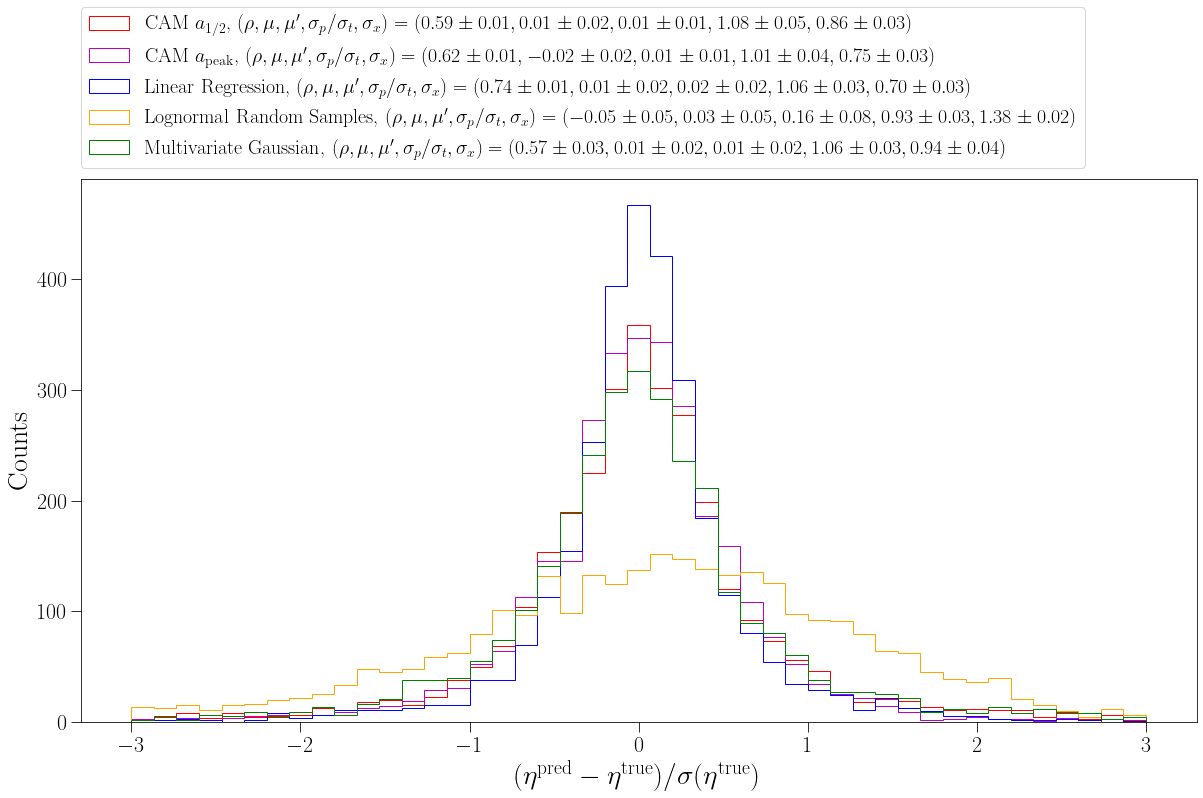

In [41]:
test_data = {'cam_1/2': (am_test, "\\rm CAM $a_{1/2}$", 'r'),
             'cam_peak': (am_test, "\\rm CAM $a_{\\rm peak}$", 'm'),
            'linear': (am_test, "\\rm Linear Regression", 'b'),
            'lognormal': (am_test, "\\rm Lognormal Random Samples", 'orange'),
            'gaussian': (am_test, "\\rm Multivariate Gaussian", 'g')}
combined_histogram(test_data, eta_test, eta_models, latex_var=r'\eta', n_bins=45, xrange=(-3, 3), 
                  calc_errs=True, cat_test=cat_test, draw_vline=False)